# DeBERTa-v3-SMALL Regression Starter
This notebook is a fork from Yuto_H's great notebook [here][1]. If you like my notebook, remember to upvote Yuto's notebook too. In this notebook we add the following modifications which are explained in my discussion post [here][3]:
* Change model to `DeBERTa-v3-small` for fast experiments (Note that `xsmall` works well too)
* Increase token `max_length to 1024` (instead of 512 to include all essay text)
* Use total `train batch size = 8`, valid batch size 16 (Note `batch per gpu = 4` and we have 2xT4 GPU)
* Train `4 epochs linear` with start `LR = 1e-5` and `no warmup`
* Remove seed everything (I like randomness)
* Add `QWK metric for regression`
* Add `new tokens` to tokenizer because DeBERTa removes "new paragraph" and "double space" from essay
* `Remove dropout` for regression
* Save `full OOF` predictions
* Add `test inference` and `LB submit`
* Achieves surprising `CV = 0.822` WOW! and LB = ??? (submitting now, let's see what LB is...)

For training, this notebook averages 1 hour per fold which is 15 minutes per epoch training on 2xT4 Kaggle GPU. (Training is done in version 1. And inference and submit to LB is done in version 2).

# Version Notes
In version 1, we finetune a new DeBERTa-v3-SMALL and save it to the Kaggle dataset [here][4]. Therefore if you want to see training epoch details, view notebook version 1. This took 6 hours using Kaggle's 2xT4 GPU.

In notebook version 2, we load the saved fold models and infer test data and submit to LB. Version 2 runs quickly because it is only inference. It will run in either 6 minutes or 1 minute depending on whether we infer OOF and compute CV score again.

If we want version 2 inference to run more quickly, we can set `COMPUTE_CV = False` below, then we will not use 5 minutes to predict OOF and compute CV score. Instead we will only infer test data.

[1]: https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
[2]: https://www.kaggle.com/code/hashidoyuto/deberta-v3-base-aes2-0-infer
[3]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832
[4]: https://www.kaggle.com/datasets/cdeotte/deberta-v3-small-finetuned-v1

# Imports and Config
Import libraries and define configuration parameters here.

In [1]:
from sklearn.linear_model import LogisticRegression
# Assume X_train, y_train are the training dataset features and labels
model = LogisticRegression()

In [2]:
import os
# This is used to select environment CPU/CPU
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# True USES REGRESSION, False USES CLASSIFICATION
USE_REGRESSION = True

# VERSION NUMBER FOR NAMING OF SAVED MODELS
VER=1

# IF "LOAD_FROM" IS None, THEN WE TRAIN NEW MODELS
LOAD_FROM = "/kaggle/input/deberta-v3-small-finetuned-v1/"

# WHEN TRAINING NEW MODELS SET COMPUTE_CV = True
# WHEN LOADING MODELS, WE CAN CHOOSE True or False
COMPUTE_CV = True


# import os

# # Specify the GPUs to be used by the CUDA application
# os.environ["CUDA_DEVICES"] = "0,1"

# # Set to True for regression tasks, False for classification tasks
# IS_REGRESSION_TASK = True

# # Model version number for naming and tracking saved models
# MODEL_VERSION = 1

# # Path to load pre-trained models from; set to None to train new models
# MODEL_LOAD_PATH = "/kaggle/input/deberta-v3-small-finetuned-v1/"

# # If True, compute cross-validation metrics during training; applicable to new model training
# # Can be True or False when loading pre-trained models
# SHOULD_COMPUTE_CV = True


In [3]:
# Import the warnings module to control the warning messages
import warnings

# Import pandas for data manipulation and analysis
import pandas as pd

# Import numpy for numerical computations
import numpy as np

# Import matplotlib.pyplot for data visualization
import matplotlib.pyplot as plt

# Import AutoTokenizer, AutoModelForSequenceClassification, and AutoConfig from the transformers library for NLP tasks
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# Import TrainingArguments and Trainer from transformers for model training
from transformers import TrainingArguments, Trainer

# Import DataCollatorWithPadding from transformers to handle dynamic padding of input sequences
from transformers import DataCollatorWithPadding

# Import Dataset from the datasets library to handle and manipulate datasets
from datasets import Dataset

# Import StratifiedKFold from sklearn for stratified k-fold cross-validation
from sklearn.model_selection import StratifiedKFold

# Import confusion_matrix and ConfusionMatrixDisplay from sklearn for generating and displaying confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import cohen_kappa_score from sklearn for calculating Cohen's kappa, a measure of inter-rater agreement
from sklearn.metrics import cohen_kappa_score

# Import AddedToken from tokenizers to add special tokens to the tokenizer
from tokenizers import AddedToken

# Ignore all warnings to keep the output clean
warnings.simplefilter('ignore')

2024-06-20 09:12:59.029328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:12:59.029419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:12:59.184117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class PATHS:
    # Path to the training dataset CSV file
    train_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
    
    # Path to the testing dataset CSV file
    test_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv'
    
    # Path to the sample submission CSV file
    sub_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv'
    
    # Path to the pre-trained DeBERTa V3 small model directory
    model_path = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-small"


| Attribute         | Description                                                                                 |
|:------------------|:--------------------------------------------------------------------------------------------|
| `n_splits`        | Defines the number of folds for cross-validation to ensure the model is evaluated on different subsets of the data.  |
| `seed`            | Sets the random seed for reproducibility, ensuring consistent results across different runs. |
| `max_length`      | Specifies the maximum length of tokenized input sequences, truncating or padding them to this length. |
| `lr`              | Sets the learning rate for the optimizer, which controls how much to adjust the model parameters during training. |
| `train_batch_size`| Defines the number of samples per batch during training.                                    |
| `eval_batch_size` | Defines the number of samples per batch during evaluation.                                  |
| `train_epochs`    | Specifies the number of complete passes through the training dataset.                       |
| `weight_decay`    | Adds a penalty to the loss to regularize the model and prevent overfitting.                 |
| `warmup_ratio`    | Specifies the fraction of the training process to linearly increase the learning rate before decaying it. |
| `num_labels`      | Indicates the number of output labels or classes for the classification task.               |


### Detailed Description:
- **`n_splits` (5)**: The number of splits for cross-validation. This means the data will be divided into 5 parts, and the model will be trained and validated 5 times, each time using a different part for validation and the rest for training.
- **`seed` (42)**: A fixed number used to initialize the random number generator, ensuring that the results are reproducible every time the code is run.
- **`max_length` (1024)**: The maximum length of the input sequences after tokenization. Sequences longer than this will be truncated, and shorter ones will be padded.
- **`lr` (1e-5)**: The learning rate for the optimizer, determining the step size during gradient descent. A lower learning rate can lead to more stable training but might require more epochs.
- **`train_batch_size` (4)**: The number of training samples processed together in one forward/backward pass. Smaller batch sizes use less memory but may lead to noisier gradient estimates.
- **`eval_batch_size` (8)**: The number of evaluation samples processed together. Larger batch sizes can speed up evaluation but require more memory.
- **`train_epochs` (4)**: The number of times the entire training dataset will be passed through the model during training.
- **`weight_decay` (0.01)**: A regularization technique to prevent overfitting by adding a penalty for large weights in the model.
- **`warmup_ratio` (0.0)**: The fraction of the total training steps during which the learning rate will linearly increase to its peak value before decaying.
- **`num_labels` (6)**: The number of distinct classes or labels that the model is expected to predict, used for classification tasks.


In [5]:
class CFG:
    # Number of splits for cross-validation
    n_splits = 3
    
    # Random seed for reproducibility
    seed = 42
    
    # Maximum token length for the input sequences
    max_length = 1024
    
    # Learning rate for the optimizer
    lr = 1e-5
    
    # Batch size for training
    train_batch_size = 4
    
    # Batch size for evaluation
    eval_batch_size = 8
    
    # Number of epochs to train the model
    train_epochs = 4
    
    # Weight decay for regularization to prevent overfitting
    weight_decay = 0.01
    
    # Warmup ratio for learning rate scheduling
    warmup_ratio = 0.0
    
    # Number of labels for classification (e.g., the number of classes in the dataset)
    num_labels = 6


In [6]:
def seed_everything(seed):
    # Import necessary modules for setting random seeds
    import random, os
    import numpy as np
    import torch
    
    # Set the random seed for the built-in random module to ensure reproducibility
    random.seed(seed)
    
    # Set the environment variable PYTHONHASHSEED to ensure reproducibility of hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Set the random seed for NumPy to ensure reproducibility of NumPy operations
    np.random.seed(seed)
    
    # Set the random seed for PyTorch to ensure reproducibility of PyTorch operations on the CPU
    torch.manual_seed(seed)
    
    # Set the random seed for PyTorch to ensure reproducibility of PyTorch operations on the GPU
    torch.cuda.manual_seed(seed)
    
    # Ensure that CUDA's convolutional operations are deterministic to enhance reproducibility
    torch.backends.cudnn.deterministic = True
    
    # Allow cuDNN to benchmark multiple algorithms for determining the fastest one; this may affect reproducibility
    torch.backends.cudnn.benchmark = True
    
# Uncomment the following line to set seeds for reproducibility using the specified seed value from CFG
# seed_everything(seed=CFG.seed)


# Data Tokenization
We use `max_length = 1024` to avoid truncating majority of essays.

In [7]:
print("Tonkenization of Data ")

Tonkenization of Data 


### Summary

The `Tokenize` class is designed to handle the tokenization of text data for training and validation datasets in a machine learning pipeline, specifically for natural language processing (NLP) tasks. It uses the HuggingFace library's `Dataset` and tokenizer utilities.

#### Key Components:

- **Initialization (`__init__` method)**:
  - Takes three parameters: training data (`train` DataFrame), validation data (`valid` DataFrame), and a tokenizer.
  - Stores the tokenizer and both DataFrames as instance variables.

- **Dataset Conversion (`get_dataset` method)**:
  - Converts a pandas DataFrame into a HuggingFace `Dataset` object.
  - Extracts `essay_id`, `full_text`, and `label` columns from the DataFrame to create the `Dataset`.

- **Tokenization (`tokenize_function` method)**:
  - Defines a function to tokenize the `full_text` from the input examples.
  - Applies truncation and sets a maximum length for the tokenized sequences based on a predefined configuration (`CFG.max_length`).

- **Execution (`__call__` method)**:
  - Converts the training and validation DataFrames into `Dataset` objects using `get_dataset`.
  - Applies the `tokenize_function` to both the training and validation `Dataset` objects using the `map` method from the HuggingFace library, which tokenizes the data in batches.
  - Returns the tokenized training and validation datasets, along with the tokenizer.

The `Tokenize` class streamlines the process of preparing text data for model training and evaluation by converting raw text into tokenized sequences suitable for input into NLP models.

In [8]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        # Store the tokenizer passed to the class
        self.tokenizer = tokenizer
        # Store the training data DataFrame
        self.train = train
        # Store the validation data DataFrame
        self.valid = valid
        
    def get_dataset(self, df):
        # Convert the DataFrame to a Dataset object from the HuggingFace library
        ds = Dataset.from_dict({
                # Extract and store the 'essay_id' column from the DataFrame
                'essay_id': [e for e in df['essay_id']],
                # Extract and store the 'full_text' column from the DataFrame
                'full_text': [ft for ft in df['full_text']],
                # Extract and store the 'label' column from the DataFrame
                'label': [s for s in df['label']],
            })
        # Return the created Dataset object
        return ds
        
    def tokenize_function(self, example):
        # Tokenize the 'full_text' from the example, apply truncation, and set max length
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        # Return the tokenized inputs
        return tokenized_inputs
    
    def __call__(self):
        # Convert the training DataFrame to a Dataset object
        train_ds = self.get_dataset(self.train)
        # Convert the validation DataFrame to a Dataset object
        valid_ds = self.get_dataset(self.valid)
        
        # Apply the tokenize_function to the training Dataset
        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        # Apply the tokenize_function to the validation Dataset
        tokenized_valid = valid_ds.map(
            self.tokenize_function, batched=True
        )
        
        # Return the tokenized training and validation Datasets, and the tokenizer
        return tokenized_train, tokenized_valid, self.tokenizer


# Compute Metrics
Below we provide compute metric function for both regression and classification. In this notebook we will use regression.

### Summary

The function `compute_metrics_for_regression` is designed to calculate and return the quadratic weighted kappa (QWK) score, a metric commonly used to evaluate the agreement between two raters, which in this case are the true labels and the model's predictions. This function is particularly useful in regression tasks where the predictions need to be assessed for their accuracy and consistency with the actual values.

#### Key Steps:

1. **Unpacking Predictions and Labels**:
   - The function takes a single argument `eval_pred`, which is a tuple containing the model's predictions and the true labels.
   - These are unpacked into the variables `predictions` and `labels`.

2. **Computing Quadratic Weighted Kappa (QWK) Score**:
   - The QWK score is calculated using the `cohen_kappa_score` function from the `sklearn.metrics` module.
   - The `predictions` are clipped to a range of 0 to 5 to match the expected label range and rounded to the nearest integer.
   - The `weights='quadratic'` parameter specifies that the quadratic version of the kappa score should be used, which gives more weight to larger disagreements.

3. **Storing the Results**:
   - The computed QWK score is stored in a dictionary with the key `'qwk'`.

4. **Returning the Results**:
   - The function returns the dictionary containing the QWK score.

This function provides a standardized way to evaluate the performance of regression models by quantifying the agreement between predicted and actual values, facilitating the comparison of model outputs in a consistent manner.

In [9]:
def compute_metrics_for_regression(eval_pred):
    # Unpack predictions and labels from the evaluation prediction tuple
    predictions, labels = eval_pred
    
    # Compute the quadratic weighted kappa score between the true labels and the predicted labels
    # Clip the predictions to be between 0 and 5, and round them to the nearest integer
    qwk = cohen_kappa_score(labels, predictions.clip(0, 5).round(0), weights='quadratic')
    
    # Create a dictionary to store the computed metric
    results = {
        'qwk': qwk
    }
    
    # Return the dictionary containing the quadratic weighted kappa score
    return results


### Summary

The `compute_metrics_for_classification` function is designed to evaluate classification model performance by computing the quadratic weighted kappa (QWK) score. This metric assesses the agreement between the true labels and the model's predictions, taking into account the degree of disagreement.

#### Key Steps:

1. **Unpacking Predictions and Labels**:
   - The function takes a single argument, `eval_pred`, which is a tuple containing the model's predictions and the true labels.
   - These are unpacked into the variables `predictions` and `labels`.

2. **Computing Quadratic Weighted Kappa (QWK) Score**:
   - The QWK score is calculated using the `cohen_kappa_score` function from the `sklearn.metrics` module.
   - The `predictions` are converted to class labels by taking the `argmax` (the index of the highest value) along the last axis, which corresponds to the predicted class.
   - The `weights='quadratic'` parameter specifies that the quadratic version of the kappa score should be used, which gives more weight to larger disagreements.

3. **Storing the Results**:
   - The computed QWK score is stored in a dictionary with the key `'qwk'`.

4. **Returning the Results**:
   - The function returns the dictionary containing the QWK score.

This function provides a standardized way to evaluate the performance of classification models by quantifying the agreement between predicted and actual class labels, facilitating the comparison of model outputs in a consistent manner.

In [10]:
def compute_metrics_for_classification(eval_pred):
    # Unpack predictions and labels from the evaluation prediction tuple
    predictions, labels = eval_pred
    
    # Compute the quadratic weighted kappa score between the true labels and the predicted labels
    # Use argmax to get the predicted class with the highest probability
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    
    # Create a dictionary to store the computed metric
    results = {
        'qwk': qwk
    }
    
    # Return the dictionary containing the quadratic weighted kappa score
    return results


# Load Data and Set Fold
For our label, we will use `label = score - 1`. Then the labels will range from 0 to 5. For regression, we convert the label to `float32`. For classification, we would convert to `int32`.

print('Loading')

In [11]:
# Read the training data from the specified CSV file path
data = pd.read_csv(PATHS.train_path)

# Adjust the scores to create labels by subtracting 1 from each score
data['label'] = data['score'].apply(lambda x: x - 1)

# If using regression, cast the 'label' column to float32 type
if USE_REGRESSION:
    data["label"] = data["label"].astype('float32')
# Otherwise, cast the 'label' column to int32 type for classification
else:
    data["label"] = data["label"].astype('int32')

# Initialize StratifiedKFold with the specified number of splits, shuffling, and random seed for reproducibility
skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

# Split the data into stratified folds
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    # Assign fold number to the validation set in each split
    data.loc[val_index, "fold"] = i

# Display the first few rows of the dataset with the new 'label' and 'fold' columns
data.head()


,essay_id,full_text,score,label,fold
0,000d118,Many people have car where they live. The thin...,3,2.0,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,2.0
2,001ab80,People always wish they had the same technolog...,4,3.0,0.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2.0,1.0


In [12]:
data_test = pd.read_csv(PATHS.test_path)

# Set Training Args
We use `fp16=True` which uses mixed precision and uses less GPU VRAM and makes training faster. We use `per_device_train_batch_size = (8 / number of gpus)` because we want total train batch size to be 8. With Kaggle T4, we have 2xT4 GPUs and use `per_device_train_batch_size = 4`.

In [13]:
training_args = TrainingArguments(
    output_dir=f'output_v{VER}',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.eval_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
    optim='adamw_torch',
    logging_first_step=True,
)

# K Fold Training
We add new tokens for ("\n") new paragraph and (" "*2) double space because the default DeBERTa tokenizer removes these but these are helpful for scoring essays. We remove dropout from our model because this does not work well when using regression. Read discussion [here][1]

[1]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832

Map:   0%|          | 0/11538 [00:00<?, ? examples/s]

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

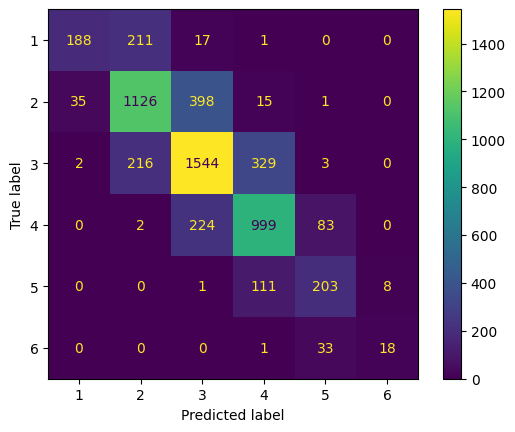

Map:   0%|          | 0/11538 [00:00<?, ? examples/s]

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

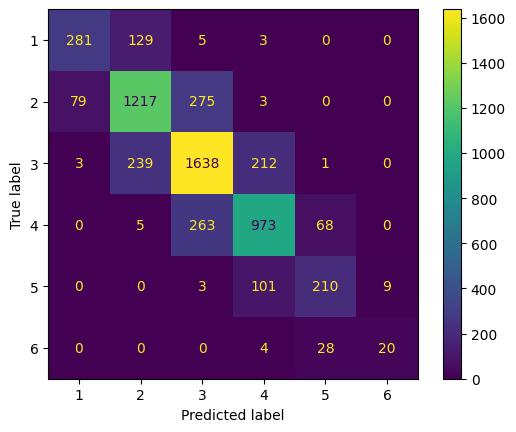

Map:   0%|          | 0/11538 [00:00<?, ? examples/s]

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

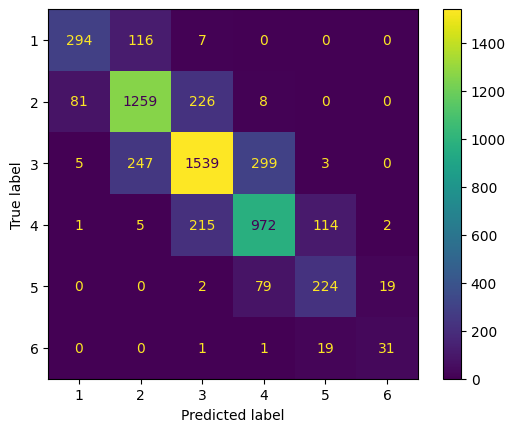

In [14]:
# computer CV
if COMPUTE_CV:
    # for fold in data
    for fold in range(len(data['fold'].unique())):

        # GET TRAIN AND VALID DATA
        train = data[data['fold'] != fold]
        valid = data[data['fold'] == fold].copy()

        # ADD NEW TOKENS for ("\n") new paragraph and (" "*2) double space 
        tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
        tokenizer.add_tokens([AddedToken("\n", normalized=False)])
        tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
        tokenize = Tokenize(train, valid, tokenizer)
        tokenized_train, tokenized_valid, _ = tokenize()

        # REMOVE DROPOUT FROM REGRESSION
        config = AutoConfig.from_pretrained(PATHS.model_path)
        if USE_REGRESSION:
            config.attention_probs_dropout_prob = 0.0 
            config.hidden_dropout_prob = 0.0 
            config.num_labels = 1 
        else: config.num_labels = CFG.num_labels 

        if LOAD_FROM:
            model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
        else:
            model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
            model.resize_token_embeddings(len(tokenizer))

        # TRAIN WITH TRAINER
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
        else: compute_metrics = compute_metrics_for_classification
        trainer = Trainer( 
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_valid,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        if LOAD_FROM is None:
            trainer.train()

        # PLOT CONFUSION MATRIX
        y_true = valid['score'].values
        predictions0 = trainer.predict(tokenized_valid).predictions
        if USE_REGRESSION: predictions = predictions0.round(0) + 1
        else: predictions = predictions0.argmax(axis=1) + 1 
        cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
        draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        draw_cm.plot()
        plt.show()

        # SAVE FOLD MODEL AND TOKENIZER
        if LOAD_FROM is None:
            trainer.save_model(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
            tokenizer.save_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')

        # SAVE OOF PREDICTIONS
        if USE_REGRESSION: 
            valid['pred'] = predictions0 + 1 
        else:
            COLS = [f'p{x}' for x in range(CFG.num_labels)] 
            valid[COLS] = predictions0 
        valid.to_csv(f'valid_df_fold_{fold}_v{VER}.csv', index=False)

# Overall CV Score

In [15]:
# If computer CV is on
if COMPUTE_CV:
    # init dfs as empty list
    dfs = []
    # do splits
    for k in range(CFG.n_splits):
        dfs.append( pd.read_csv(f'valid_df_fold_{k}_v{VER}.csv') )
        os.system(f'rm valid_df_fold_{k}_v{VER}.csv')
    dfs = pd.concat(dfs)
    dfs.to_csv(f'valid_df_v{VER}.csv',index=False)
    print('Valid OOF shape:', dfs.shape )
    display( dfs.head() )

Valid OOF shape: (17307, 6)


,essay_id,full_text,score,label,fold,pred
0,001ab80,People always wish they had the same technolog...,4,3.0,0.0,4.206856
1,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0,3.586036
2,0033037,The posibilty of a face reconizing computer wo...,2,1.0,0.0,2.445031
3,0036253,The challenge of exploring Venus\n\nThis stori...,2,1.0,0.0,2.469238
4,004229b,I do not think that driverless cars are a good...,2,1.0,0.0,2.080080


In [16]:
if COMPUTE_CV:
    if USE_REGRESSION:
        m = cohen_kappa_score(dfs.score.values, dfs.pred.values.clip(1,6).round(0), weights='quadratic')
    else:
        m = cohen_kappa_score(dfs.score.values, dfs.iloc[:,-6:].values.argmax(axis=1)+1, weights='quadratic')
    print('Overall QWK CV =',m)

Overall QWK CV = 0.8655179636854253


# Infer Test Data
We infer test data using Hugging Face trainer and load our saved best fold models.

In [17]:
test = pd.read_csv(PATHS.test_path)
print('Testing..')
print('Test shape:', test.shape )
test.head()

Testing..
Test shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [18]:
all_pred = []
test['label'] = 0.0

for fold in range(CFG.n_splits):
    
    # LOAD TOKENIZER
    if LOAD_FROM:
        tokenizer = AutoTokenizer.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        tokenizer = AutoTokenizer.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    tokenize = Tokenize(test, test, tokenizer)
    tokenized_test, _, _ = tokenize()

    # LOAD MODEL
    if LOAD_FROM:
        model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        model = AutoModelForSequenceClassification.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    
    # INFER WITH TRAINER
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer( 
        model=model,
        args=training_args,
        train_dataset=tokenized_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # SAVE PREDICTIONS
    predictions = trainer.predict(tokenized_test).predictions
    all_pred.append( predictions )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [19]:
preds = np.mean(all_pred, axis=0)
print('Predictions shape:',preds.shape)

Predictions shape: (3,)


# Create Submission CSV

### Summary

The following code prepares and processes submission data for a machine learning competition. It reads a sample submission file, adjusts predictions based on whether regression or classification is used, and writes the adjusted predictions to a new submission file.

#### Code Steps:

1. **Read Sample Submission**:
   ```python
   sub = pd.read_csv(PATHS.sub_path)
   ```
   - Reads the sample submission CSV file.

2. **Adjust Predictions**:
   ```python
   if USE_REGRESSION:
       sub["score"] = preds.clip(0, 5).round(0) + 1
   else:
       sub["score"] = preds.argmax(axis=1) + 1
   ```
   - If regression is used, clips and rounds predictions, then adds 1.
   - If classification is used, takes the argmax of predictions and adds 1.

3. **Convert Data Type**:
   ```python
   sub.score = sub.score.astype('int32')
   ```
   - Converts the `score` column to `int32` type.

4. **Save Submission**:
   ```python
   sub.to_csv('submission.csv', index=False)
   ```
   - Writes the adjusted predictions to a CSV file named `submission.csv`.

5. **Print Submission Shape**:
   ```python
   print('Submission shape:', sub.shape)
   ```
   - Prints the shape of the submission DataFrame.

6. **Display Submission Data**:
   ```python
   sub.head()
   ```
   - Displays the first few rows of the submission DataFrame.

This code ensures that the predictions are properly formatted and ready for submission, adhering to the requirements of the competition.

In [20]:
# Read the sample submission data from the specified CSV file path
sub = pd.read_csv(PATHS.sub_path)

# If using regression, clip predictions between 0 and 5, round them to the nearest integer, and add 1 to match the original score range
if USE_REGRESSION:
    sub["score"] = preds.clip(0, 5).round(0) + 1
# Otherwise, for classification, take the class with the highest predicted probability (argmax) and add 1 to match the original score range
else:
    sub["score"] = preds.argmax(axis=1) + 1

# Convert the 'score' column to int32 type to ensure correct data type
sub.score = sub.score.astype('int32')

# Save the modified submission DataFrame to a new CSV file named 'submission.csv'
sub.to_csv('submission.csv', index=False)

# Print the shape of the submission DataFrame to verify its dimensions
print('Submission shape:', sub.shape)

# Display the first few rows of the submission DataFrame to inspect the results
sub.head()

Submission shape: (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
